# Predicting prevalence of hyperglycemia on Zila level

## Content

- Data cleaning and preprocessing: DHS and SVRS
- Model fine-tuning using XGBoost
- SVRS: Data preprocessing and preparation
- Predicting and writing output for SVRS data

## Notes

- Definition of diabetes:
    - Recommendation for diagnosis of diabetes [WHO](https://www.who.int/diabetes/publications/Definition%20and%20diagnosis%20of%20diabetes_new.pdf)
- Hyperglycemia if meets any of the following three criteria:
    - FBG ≥ 126 mg/dl (7.0 mmol/l)
    - Doctor/nurse diagnosed diabetes
    - Taking diabetes medication

## Packages

In [1]:
import os
import re
import glob
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import itertools
import collections
import logging
import numpy as np
import pandas as pd
import pandas_ml as pd_ml
import seaborn as sns
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


from datetime import timedelta
from datetime import datetime as dt

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import confusion_matrix


## Custom functions

In [20]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
            df.at[key, 'hypertension'] = 1
        elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
            df.at[key, 'hypertension'] = 0
        else:
            df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def get_svrs_metadata(path, pattern):
    out_files = []
    for path, subdirs, files in os.walk(path):
        out_files = out_files + [os.path.join(path,file) for file in files if bool(re.search(pattern=pattern,string=file))]
    return out_files

def search_pattern(input_df, var, pattern):
    df = input_df.copy(deep=True)
    subset = [bool(re.search(pattern=pattern, string=var)) for var in df[var]]
    return df[subset]


```
def read_svrs(path, pattern):
    data = {}
    original_variables = {}
    for path, subdir, files in os.walk(path):
        for file in files:
            if file.endswith(pattern):
                itr = pd.read_stata(os.path.join(path,file), iterator=True)
                variables = list(itr.variable_labels().values())
                data[file] = pd.read_stata(os.path.join(path,file))
                original_variables[file] = list(data[file].columns)
                data[file].columns = variables
    return data, original_variables
```

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'

## Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


In [5]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shsd3,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ncd_metadata.columns
ncd_metadata.tail()

,variable,description,model_keep,num_values,type
377,shsmk,NA - Respondent smoking practices,1,1,categorical
378,shresi,Result of individual interview,1,7,categorical
379,shed1,Member's highest educational level,1,5,categorical
380,shed2,Member's highest year of education,1,21,numeric
381,shed3,Highest educational level (CS for preliminary ...,1,7,categorical


In [7]:
for var in ncd_metadata['description']:
    if bool(re.search("Sex|sex", var)):
        print(var)
        print(ncd_metadata[ncd_metadata['description'] == var])
        print("#"*100)

Sex of head of household
   variable               description  model_keep  num_values         type
56    hv219  Sex of head of household           1           2  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member           1           2  categorical
299    sh231  Sex of household member           1           3  categorical
####################################################################################################
Sex
    variable description  model_keep  num_values         type
239     hc27         Sex           1           3  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member         

## Creating hyperglycaemia target variable

In [8]:
ncd_data = determine_hyperglycaemia(input_df=ncd_data)
print(ncd_data['hyperglycaemia'].value_counts())

-9    74896
 0     6632
 1     2203
Name: hyperglycaemia, dtype: int64


In [9]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [10]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shed2,shed3,meal,drink,measure_time,meal_delta,meal_fasting,drink_delta,drink_fasting,hyperglycaemia
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9


### Subset data by target variable missingness

In [11]:
data = subset_by_var2(input_df=ncd_data, var='hyperglycaemia')
'hyperglycaemia' in data.columns

(83731, 391)
(8835, 391)


True

### Subset data by metadata file (variables to keep column)

In [12]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hyperglycaemia' in data.columns

(8835, 391)
(8835, 314)


True

### Remove uniformed variables (no variation)

In [13]:
data = remove_uniform(input_df=data)
'hyperglycaemia' in data.columns

(8835, 314)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(8835, 303)


True

### Removing missing by threshold 

```
data1 = remove_missing(input_df=data, threshold=0.1)
'hyperglycaemia' in data.columns
```

### Checking variables

In [14]:
check_variables(input_df=data)

[]

### Removing meta variables

In [15]:
data = data.drop(['Unnamed: 0', 'meal', 'drink', 'measure_time', 'meal_delta', 'meal_fasting', 'drink_delta', 'drink_fasting'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,shsd3,shbm,shri,shcmc,shsmk,shresi,shed1,shed2,shed3,hyperglycaemia
12,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,917.0,NaN,2.0,1.0,3.0,1.0,1
16,6,0,0,6,2,1,10,1,1,2,...,-88.0,2119.0,1385.0,642.0,NaN,NaN,0.0,NaN,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,614.0,NaN,NaN,1.0,3.0,1.0,0
26,5,1,1,5,5,1,10,1,1,2,...,-149.0,2068.0,1337.0,907.0,NaN,1.0,1.0,2.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,9999.0,9999.0,9999.0,556.0,NaN,NaN,0.0,NaN,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

In [16]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108','hv105','hv025','hv104', 'hyperglycaemia']]
orig_data.columns = variables + ['Hyperglycaemia']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Hyperglycaemia'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.columns

Index(['Education', 'Age', 'Urban/Rural', 'Gender', 'Hyperglycaemia'], dtype='object')

In [18]:
orig_data['Education'].value_counts()
orig_data['Education'].max()

18

In [18]:
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
y = orig_data['Hyperglycaemia']
X = orig_data.drop(['Hyperglycaemia'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Education        int64
Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
dtype: object

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hyperglycemia

In [20]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hyperglycaemia'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy : %.4g {metrics.accuracy_score(dtrain['Hyperglycaemia'].values, dtrain_predictions)}")
    print(f"AUC Score (Train): {metrics.roc_auc_score(dtrain['Hyperglycaemia'], dtrain_predprob)}]")
    
    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = X_data_test.merge(dtest[['predprob']])
    print(f"AUC Score (Test): {metrics.roc_auc_score(results['Hyperglycaemia'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [21]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hyperglycaemia'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hyperglycaemia'] = y_test


Model Report
Accuracy : %.4g 0.7546342153671997
AUC Score (Train): 0.6363586502860237]
AUC Score (Test): 0.5497231944455901
gbtree


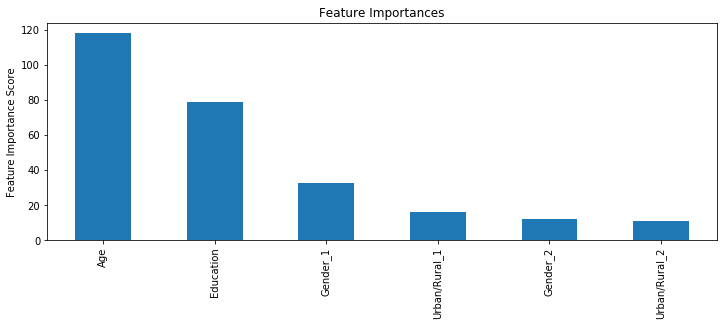

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
target = 'Hyperglycaemia'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on max_depth and min_child_weight: Initial step

In [22]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,10,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [23]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_

{'max_depth': 3, 'min_child_weight': 9}
0.5921207067706626
####################################################################################################


## Grid seach on max_depth and min_child_weight: Step 2

In [24]:
param_test2 = {
    'max_depth':[1,2,3,4,5],
    'min_child_weight':[7,8,9,10,11,12]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=3,
                                        min_child_weight=7, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=7, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [1, 2, 3, 4, 5], 'min_child_weight': [7, 8, 9, 10, 11, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [25]:
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)
#gsearch2.cv_results_,gsearch2.best_params_, gsearch2.best_score_

{'max_depth': 2, 'min_child_weight': 10}
0.5977529417019133
####################################################################################################


## Grid seach on max_depth and min_child_weight: Double check

In [26]:
param_test3 = {
    'max_depth':[1,2,3],
    'min_child_weight':[1,2,3,4,5]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [1, 2, 3], 'min_child_weight': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)
#gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_

{'max_depth': 2, 'min_child_weight': 3}
0.5975937200493292
####################################################################################################


## Grid seach on gamma: Initial step

In [28]:

#Choose all predictors except target & IDcols
param_test4 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [29]:
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)
# gsearch4.cv_results_,gsearch4.best_params_, gsearch4.best_score_

{'gamma': 0.0}
0.5977529417019133
####################################################################################################


# Evaluate importance and accuracy


Model Report
Accuracy : %.4g 0.7550587236451111
AUC Score (Train): 0.6173824376327374]
AUC Score (Test): 0.5805506678189266
gbtree


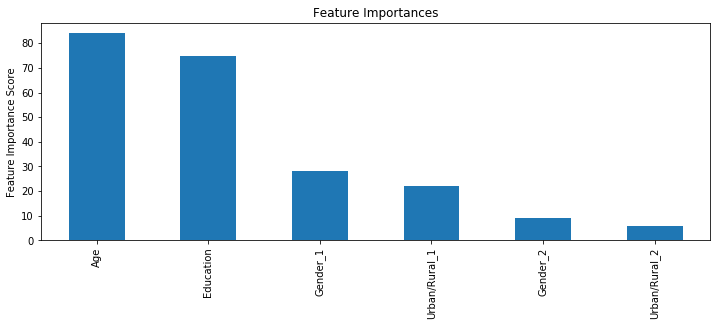

In [30]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=2,
        min_child_weight=4,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [31]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [32]:
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_

{'colsample_bytree': 0.6, 'subsample': 0.9}
0.599050211942435
####################################################################################################


## Grid seach on subsample and colsample_bytree:  Fine-tune

In [33]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(80,100,5)],
    'colsample_bytree':[i/100.0 for i in range(50,70,5)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.5, 0.55, 0.6, 0.65]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_

{'colsample_bytree': 0.5, 'subsample': 0.9}
0.599050211942435
####################################################################################################


## Grid seach on reg_alpha: Initial step

In [35]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.5,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_


{'reg_alpha': 0.1}
0.5992333383373312
####################################################################################################


## Grid seach on reg_alpha: Fine-tune

In [37]:
#Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[0.01,0.05, 0.1, 1, 2, 5, 10]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.9, colsample_bytree=0.5,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0.01, 0.05, 0.1, 1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_

{'reg_alpha': 5}
0.6002142816245841
####################################################################################################


In [39]:
#Choose all predictors except target & IDcols
param_test9 = {
    'reg_alpha':[0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=2,
                                        min_child_weight=10, gamma=0, subsample=0.9, colsample_bytree=0.5,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch9.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.9),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [40]:
print(gsearch9.best_params_)
print(gsearch9.best_score_)
print("#"*100)
# gsearch9.cv_results_,gsearch9.best_params_, gsearch9.best_score_

{'reg_alpha': 3}
0.6002829774792635
####################################################################################################



Model Report
Accuracy : %.4g 0.7535021932927692
AUC Score (Train): 0.6169790203862028]
AUC Score (Test): 0.5790106229792402
gbtree


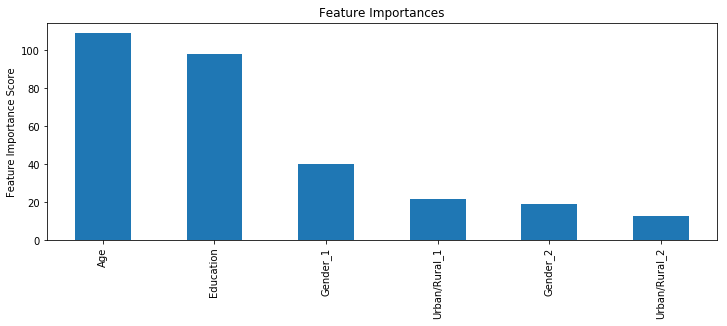

In [26]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=2,
        min_child_weight=10,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.5,
        reg_alpha=3,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

# Predicting hyperglycemia prevalence using SVRS 2013, 2014 and 2017 data

- SVRS 2012: DBF
- SVRS 2013: SAV
- SVRS 2014: SAV
- SVRS 2015: DBF
- SVRS 2017: DTA

In [ ]:
for var in ncd_data.columns: 
    print(var,len(ncd_data[var].value_counts()))

In [29]:
def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp/(tp + fp) # positive predictive value
        recall = tp/(tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],
tr = eer_threshold(model=xgb3,test_X=X_test, test_y=y_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


,EER
0.29,0.037757
0.28,0.039233
0.3,0.072128
0.27,0.083131
0.31,0.121366
0.26,0.134499
0.32,0.150931
0.33,0.181024
0.25,0.184623
0.34,0.208217


0.036062378167641324


0.06746031746031746

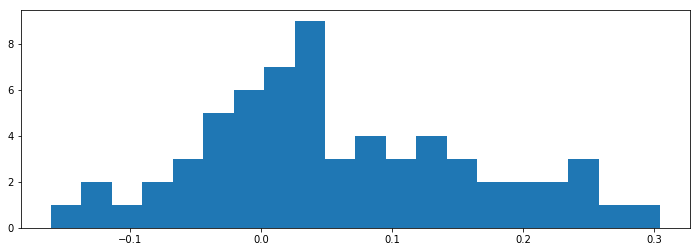

In [30]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.29, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

0.06314127861089189


0.05123619972352063

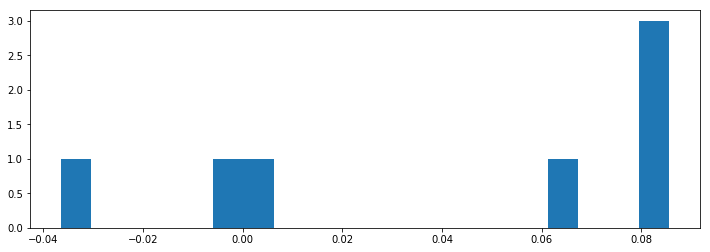

In [31]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.29, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [32]:
from sklearn.metrics import confusion_matrix
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.29, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm1)


Predicted  False  True  __all__
Actual                         
False         22     8       30
True           5     3        8
__all__       27    11       38


In [33]:
from sklearn.metrics import average_precision_score
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1339
           1       0.34      0.31      0.32       428

   micro avg       0.69      0.69      0.69      1767
   macro avg       0.56      0.56      0.56      1767
weighted avg       0.68      0.69      0.68      1767



In [22]:
import os
import sys
import glob
import tzlocal
import numpy as np
import pandas as pd
from scipy import io
from dbfread import DBF
from collections import Counter
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri
from simpledbf import Dbf5
from dbfread import DBF

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

In [23]:
SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']

## SVRS2012

In [24]:
data_svrs2012r.columns

NameError: name 'data_svrs2012r' is not defined

In [25]:
data_svrs2012r = read_dbf(SVRS2012)
data_svrs2012 = data_svrs2012r.copy(deep=True)
data_svrs2012 = data_svrs2012r[['Q_16', 'Q_11', 'RMO', 'Q_12']]
data_svrs2012.columns = variables
data_svrs2012 = data_svrs2012[data_svrs2012['Education'] != 99]
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_16'] != 99]
data_svrs2012['Urban/Rural'] = np.where(data_svrs2012['Urban/Rural'] != '1', 2, 1)
data_svrs2012['Urban/Rural'] = data_svrs2012['Urban/Rural'].astype(int).astype('category')
data_svrs2012['Gender'] = data_svrs2012['Urban/Rural'].astype(int).astype('category')
data_svrs2012 = pd.get_dummies(data_svrs2012)
data_svrs2012.head()

,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,10,60,1,0,1,0
1,8,41,1,0,1,0
2,8,14,1,0,1,0
3,11,19,1,0,1,0
4,5,48,1,0,1,0


In [16]:
print(data_svrs2012r.shape)
print(data_svrs2012.shape)

(1116335, 27)
(1116335, 6)


## SVRS2013

In [ ]:
data_svrs2013r = read_sav(SVRS2013)

In [44]:
for var in data_svrs2013r.columns:
    print(var, len(data_svrs2013r[var].value_counts()))

PSU 1500
HHNO 273
div 7
zila 64
upz 95
union 95
mauza 740
RMO 4
Q9 32
Q11 100
Q12 2
Q13 5
Q14 5
Q15 5
Q16 18
Q17 2
Q18 3
Q19 2
Q20 5
Q21 31
stratum 128
hhweight 128
Q1 2
Q2 6
Q2A1 41
Q2A2 1159
Q2B1 44
Q2B2 1221
Q2C1 51
Q2C2 1319
Q2D1 34
Q2D2 798
Q2E1 19
Q2E2 455
Q2F1 6
Q2F2 101
Q3A 7
Q3B 7
Q4 6
Q5 3
Q6 7
Q7 4
Q8 5
OP_ID 41


In [64]:
#display(data_svrs2013r.head())
print(data_svrs2013r.columns)
# OK: print(data_svrs2013r['Q11'].value_counts().sort_index()) # Age
# OK: print(data_svrs2013r['Q12'].value_counts().sort_index()) # Sex
# OK: print(data_svrs2013r['RMO'].value_counts()) # Have to check three levels: of RMO
# !!! Education correction: print(data_svrs2013['Q16'].value_counts()) # Education
print(data_svrs2013r['Q16'].value_counts())
print(len(data_svrs2013r['Q16'].value_counts()))
print(data_svrs2014r['Q16'].value_counts().sort_values(ascending=False))
print(len(data_svrs2014r['Q16'].value_counts()))

Index(['PSU', 'HHNO', 'div', 'zila', 'upz', 'union', 'mauza', 'RMO', 'Q9',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'stratum', 'hhweight', 'Q1', 'Q2', 'Q2A1', 'Q2A2', 'Q2B1',
       'Q2B2', 'Q2C1', 'Q2C2', 'Q2D1', 'Q2D2', 'Q2E1', 'Q2E2', 'Q2F1', 'Q2F2',
       'Q3A', 'Q3B', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'OP_ID'],
      dtype='object')
None                         151660
Class V passed                79700
SSC or equvalent              49139
Class VIII passed             39721
Class IXpassed                37609
Class II passed               37346
Class IV passed               34849
Class III passed              33904
HSC or equvalent              30952
Class I passed                28689
Class VII passed              26147
Class VI passed               25854
Degree or equvalent           21060
Masters or equvalent          10540
Doctor.Engineer/Krishibid      2791
Diploma                        1329
Other                          1072
V

## SVRS2014

In [18]:
# print(data_svrs2014.columns)
# print(data_svrs2014['Q11'].value_counts().sort_index()) # Age
# print(data_svrs2014['Q16'].value_counts().sort_index()) # Education
# print(data_svrs2014['Q12'].value_counts()) # Sex
# print(data_svrs2014['RMO'].value_counts()) # Have to check three levels: of RMO

In [19]:
data_svrs2014r = read_sav(SVRS2014)
data_svrs2014 = data_svrs2014r.copy(deep=True)
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'].notna()]
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != 'Other']
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != '4.05']
data_svrs2014 = data_svrs2014[data_svrs2014['Q16'] != '99']
data_svrs2014 = data_svrs2014[['Q16', 'Q11', 'RMO', 'Q12']]
data_svrs2014.columns = variables
data_svrs2014['Educationucation'] = data_svrs2014['Education'].astype(int)
data_svrs2014['Age'] = data_svrs2014['Age'].astype(int)
data_svrs2014['Urban/Rural'] = np.where(data_svrs2014['Urban/Rural'] != 'Rural', 2, 1)
print(data_svrs2014['Urban/Rural'].value_counts())
data_svrs2014['Urban/Rural'] = data_svrs2014['Urban/Rural'].astype(int).astype('category')
data_svrs2014['Gender'] = np.where(data_svrs2014['Gender'] == 'Male', 1, 2)
data_svrs2014['Gender'] = data_svrs2014['Gender'].astype(int).astype('category')
data_svrs2014 = data_svrs2014[data_svrs2014['Education'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 'Other']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '4.05']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '99']
data_svrs2014 = pd.get_dummies(data_svrs2014)
data_svrs2014.head()

NameError: name 'read_sav' is not defined

## SVRS2015

In [21]:
# print(data_svrs2015.columns)
# print(data_svrs2015['Q_11'].value_counts().sort_index()) # Sex
# print(data_svrs2015['Q_10'].value_counts().sort_index()) # Age
# print(data_svrs2015['Q_16'].value_counts().sort_index()) # Education
# print(data_svrs2015['RMO'].value_counts()) # Have to check three levels: of RMO

In [22]:
data_svrs2015r = read_dbf(SVRS2015)
data_svrs2015 = data_svrs2015r.copy(deep=True)
print(variables)
data_svrs2015 = data_svrs2015[['Q_16', 'Q_10', 'RMO', 'Q_11']]
data_svrs2015.columns = variables
print(data_svrs2015.dtypes)
print(data_svrs2015['Urban/Rural'].value_counts())
data_svrs2015['Urban/Rural'] = np.where(data_svrs2015['Urban/Rural'] != '1', 2, 1)
print(data_svrs2015['Urban/Rural'].value_counts())
data_svrs2015['Urban/Rural'] = data_svrs2015['Urban/Rural'].astype(int).astype('category')
data_svrs2015['Gender'] = data_svrs2015['Gender'].astype(int).astype('category')
data_svrs2015 = data_svrs2015[data_svrs2015['Education'] != 99]
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_16'] != 99]
data_svrs2015 = pd.get_dummies(data_svrs2015)
data_svrs2015.head()

['Education', 'Age', 'Urban/Rural', 'Gender']
Education       int64
Age             int64
Urban/Rural    object
Gender          int64
dtype: object
1    566771
2    215526
3    136780
4     20453
Name: Urban/Rural, dtype: int64
1    566771
2    372759
Name: Urban/Rural, dtype: int64


,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,13,53,0,1,1,0
1,9,43,0,1,0,1
2,6,13,0,1,1,0
3,10,21,0,1,1,0
4,7,46,0,1,1,0


In [23]:
print(data_svrs2015r.shape)
print(data_svrs2015.shape)

(938418, 21)
(938418, 6)


## SVRS2017

In [24]:
# print(data_svrs2017.columns)
# print(data_svrs2017['Q_11'].value_counts().sort_index()) # Sex
# print(data_svrs2017['Q_10'].value_counts().sort_index()) # Age
# print(data_svrs2017['Q_16'].value_counts().sort_index()) # Education
# print(data_svrs2017['RMO'].value_counts()) # Have to check three levels: of RMO

In [25]:
data_svrs2017r, original_variables = read_svrs(SVRS2017)
data_svrs2017 = data_svrs2017r[['  Level of Education', '  Age', '  Rural Urban code','  Sex']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2017.columns = variables
print(data_svrs2017.shape)
data_svrs2017 = data_svrs2017[data_svrs2017['Urban/Rural'] != 9]
data_svrs2017 = data_svrs2017[data_svrs2017['Urban/Rural'] != 3]
data_svrs2017 = data_svrs2017[data_svrs2017['Education'] != 99]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 9]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 3]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Level of Education'] != 99]
data_svrs2017['Urban/Rural'] = data_svrs2017['Urban/Rural'].astype(int).astype('category')
print(data_svrs2017['Urban/Rural'].value_counts())
print(data_svrs2017['Gender'].value_counts())
data_svrs2017['Gender'] = data_svrs2017['Gender'].astype(int).astype('category')
data_svrs2017 = pd.get_dummies(data_svrs2017)
print(data_svrs2017.shape)
data_svrs2017.head()

(1252581, 4)
1    699584
2    210929
Name: Urban/Rural, dtype: int64
1.0    455602
2.0    454911
Name: Gender, dtype: int64
(910513, 6)


,Education,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2
0,10.0,22.0,0,1,1,0
1,8.0,12.0,0,1,1,0
2,13.0,55.0,0,1,0,1
3,9.0,45.0,0,1,0,1
4,7.0,53.0,0,1,1,0


In [26]:
print(data_svrs2017r.shape)
print(data_svrs2017.shape)

(910513, 30)
(910513, 6)


In [39]:
print(data_svrs2012r['Q_11'].value_counts().sort_index()[18:].sum()/data_svrs2012r['Q_11'].value_counts().sort_index().sum())
print(data_svrs2014r['Q11'].value_counts().sort_index()[18:].sum()/data_svrs2014r['Q11'].value_counts().sort_index().sum())
print(data_svrs2015r['Q_10'].value_counts().sort_index()[18:].sum()/data_svrs2015r['Q_10'].value_counts().sort_index().sum())
print(data_svrs2017r['  Age'].value_counts().sort_index()[18:].sum()/data_svrs2017r['  Age'].value_counts().sort_index().sum())


0.626079984950754
0.7075887684476805
0.6325166397063995
0.6375658557318786


# Prediting hyperglycemia and writing results out

In [139]:
data_svrs2012r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2012)[:,1]
data_svrs2012r['Hyperglycaemia'] = np.where(data_svrs2012r['Hyperglycaemia'] > 0.35, 1, 0)
data_svrs2014r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2014)[:,1]
data_svrs2014r['Hyperglycaemia'] = np.where(data_svrs2014r['Hyperglycaemia'] > 0.35, 1, 0)
data_svrs2015r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2015)[:,1]
data_svrs2015r['Hyperglycaemia'] = np.where(data_svrs2015r['Hyperglycaemia'] > 0.35, 1, 0)
data_svrs2017r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2017)[:,1]
data_svrs2017r['Hyperglycaemia'] = np.where(data_svrs2017r['Hyperglycaemia'] > 0.35, 1, 0)

In [140]:
print(f"Predictions for 2012:\n {data_svrs2012r['Hyperglycaemia'].value_counts()/data_svrs2012r.shape[0]*100}")
print(f"Predictions for 2014:\n {data_svrs2014r['Hyperglycaemia'].value_counts()/data_svrs2014r.shape[0]*100}")
print(f"Predictions for 2015:\n {data_svrs2015r['Hyperglycaemia'].value_counts()/data_svrs2015r.shape[0]*100}")
print(f"Predictions for 2017:\n {data_svrs2017r['Hyperglycaemia'].value_counts()/data_svrs2017r.shape[0]*100}")

Predictions for 2012:
 0    95.453605
1     4.546395
Name: Hyperglycaemia, dtype: float64
Predictions for 2014:
 0    93.90633
1     6.09367
Name: Hyperglycaemia, dtype: float64
Predictions for 2015:
 0    94.427537
1     5.572463
Name: Hyperglycaemia, dtype: float64
Predictions for 2017:
 0    93.825788
1     6.174212
Name: Hyperglycaemia, dtype: float64


# Writing results out

In [141]:
OUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/'

## Writing out 2012

In [142]:
data_svrs2012r["DIVN_ZILA"] = data_svrs2012r["DIVN"].str.cat(data_svrs2012r["ZILA"])
tmp1 = data_svrs2012r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2012r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2012.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,1004,764,13868,5.51
1,1006,1468,19779,7.42
2,1009,636,16751,3.80
3,1042,799,12628,6.33
4,1078,753,16258,4.63


## Writing out 2014

In [143]:
data_svrs2014r["DIVN_ZILA"] = data_svrs2014r["zila"]
tmp1 = data_svrs2014r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2014r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2014.csv', index=False, index_label=False)
tmp.head()## Writing out 2012


,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,Bagerhat,450,5440,8.27
1,Bandarban,41,1948,2.10
2,Barguna,337,4528,7.44
3,Barisal,2035,28069,7.25
4,Bhola,443,8685,5.10


## Writing out 2015

In [144]:
data_svrs2015r["DIVN_ZILA"] = data_svrs2015r["ZILA"]
tmp1 = data_svrs2015r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2015r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2015.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,01,834,9270,9.00
1,03,91,3628,2.51
2,04,583,7773,7.50
3,06,2636,45334,5.81
4,09,1119,15993,7.00


## Writing out 2017

In [145]:
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["Zila code"].astype(int).astype(str)
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["DIVN_ZILA"].str.pad(width=2, side='left', fillchar='0')
tmp1 = data_svrs2017r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2017r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2017.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,01,1191,12012,9.92
1,03,78,3295,2.37
2,04,771,9631,8.01
3,06,1551,21077,7.36
4,09,1001,15341,6.52
